In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
from sd_pipeline import StableDiffusion3Pipeline
from diffusers import StableDiffusion3Pipeline as StableDiffusion3PipelineVanilla
from sd_processor import JointAttnProcessor2_0

pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-medium", torch_dtype=torch.bfloat16)
pipe_vanilla = StableDiffusion3PipelineVanilla.from_pretrained("stabilityai/stable-diffusion-3.5-medium", torch_dtype=torch.bfloat16)
pipe = pipe.to("cuda")
pipe_vanilla = pipe_vanilla.to("cuda")

In [ ]:
negative_prompt = "there are cranes"
pipe.tokenizer.tokenize(negative_prompt)
for block in pipe.transformer.transformer_blocks:
    block.attn.processor = JointAttnProcessor2_0()
    block.attn.processor.neg_prompt_len=len(pipe.tokenizer.tokenize(negative_prompt)) + 1

In [ ]:
# run it without negative prompt, if it has the element then count it. Or generate it using a prompt, find what is in it, then use that as negative prompt. and make sure everything else is the same

seed 2842823505


100%|██████████| 16/16 [00:05<00:00,  2.79it/s]


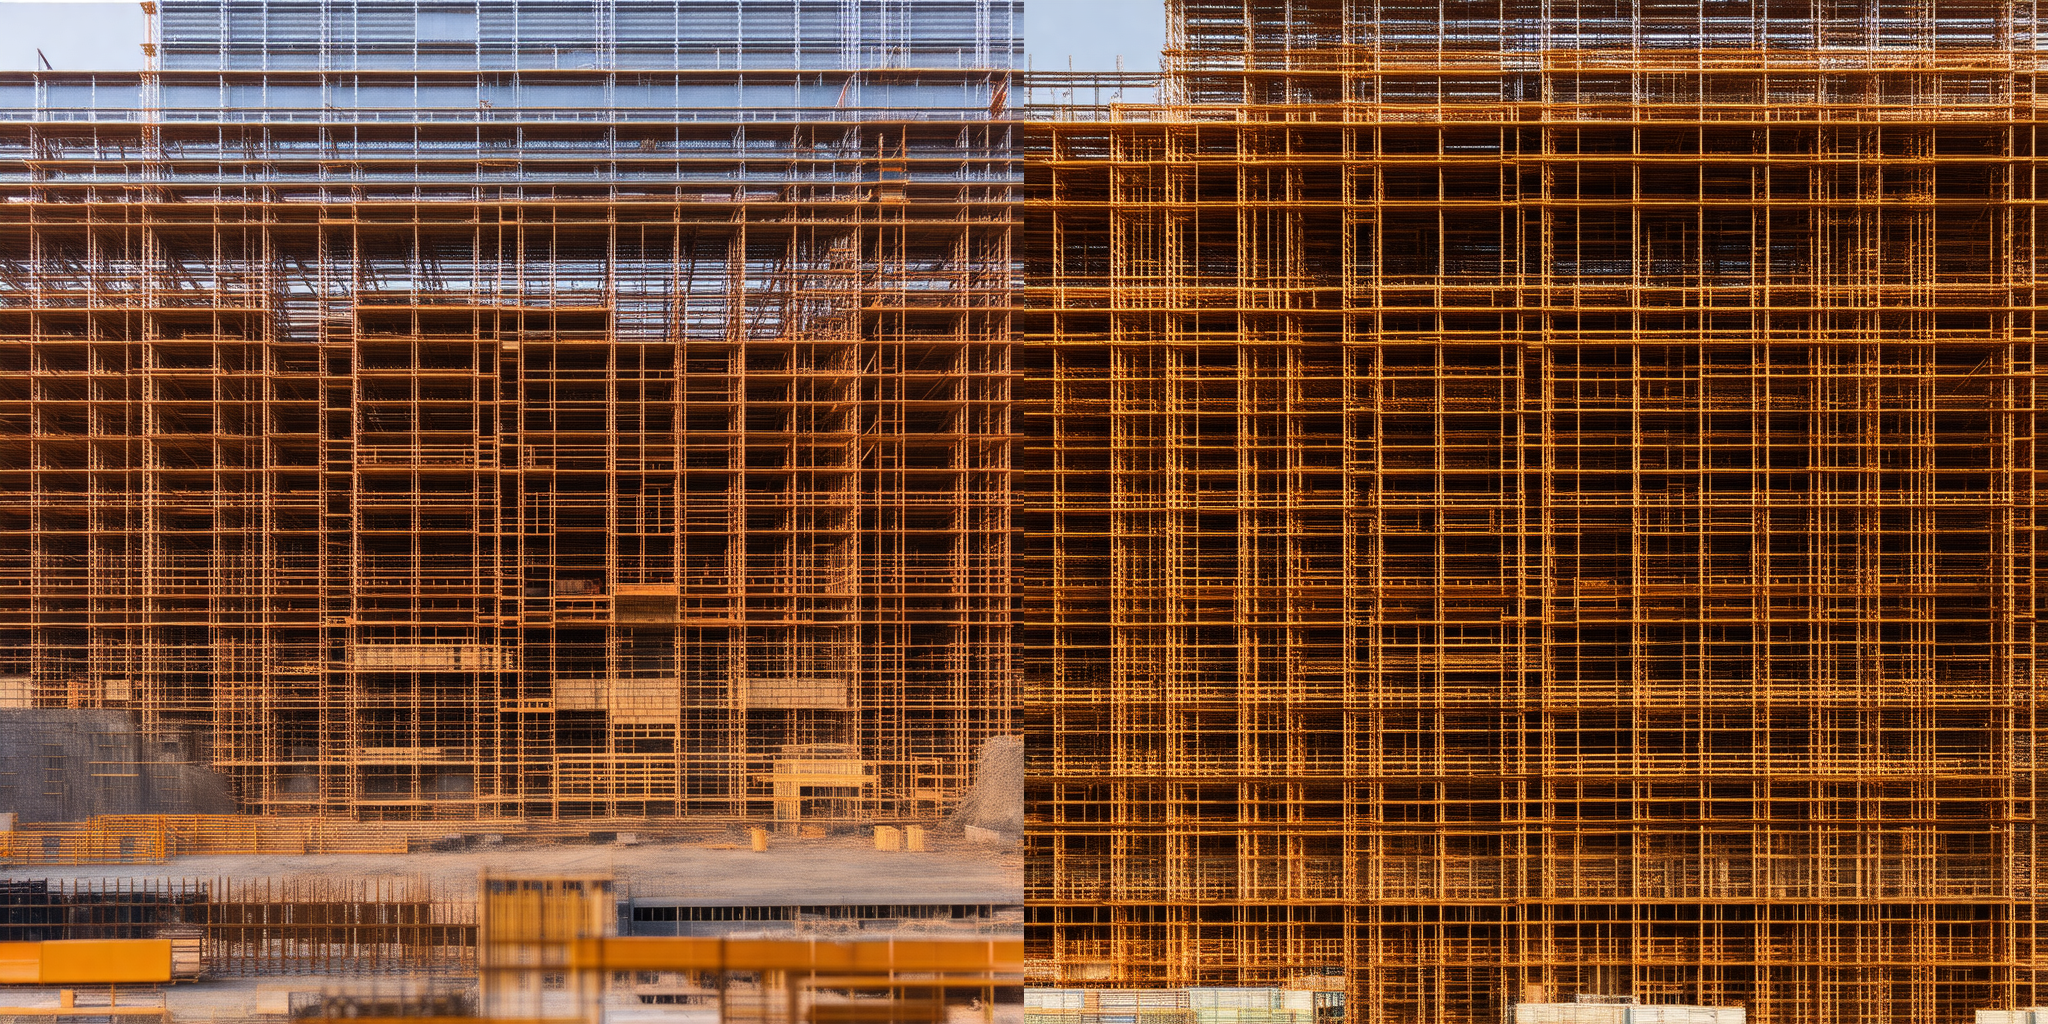

In [14]:
import os
import random
os.makedirs("random_sweeps", exist_ok=True)
# negative_prompt = "there are snow" 


pipe.tokenizer.tokenize(negative_prompt) 
for block in pipe.transformer.transformer_blocks: 
    block.attn.processor = JointAttnProcessor2_0()
    block.attn.processor.neg_prompt_len=len(pipe.tokenizer.tokenize(negative_prompt)) + 1

seed = random.randint(0, 2**32 - 1)
print("seed", seed)
# increase positive if it drops?/
images = pipe( 
    "A large construction site, the framework of a new building visible.", 
    negative_prompt=negative_prompt,
    num_inference_steps=16,
    avoidance_factor=7,
    guidance_scale=7, 
    negative_offset=-12,
    generator=torch.manual_seed(seed),
).images

# when steps is less, it sometimes failed to guide negative
vanilla_images = pipe_vanilla(
    "A large construction site, the framework of a new building visible.", 
    negative_prompt=negative_prompt,
    num_inference_steps=16,
    guidance_scale=7,
    generator=torch.manual_seed(seed),
).images

import pylab
import numpy as np
from PIL import Image  

Image.fromarray(np.concatenate([np.array(images[-1]), np.array(vanilla_images[-1])], axis=1))
# why if you keep runing this cell they will look closer and closer

In [ ]:
import pylab
map = pipe.weight_maps[5].cpu().float()
pylab.imshow(map)
pylab.colorbar() 

In [ ]:
import pylab
line = (torch.stack(pipe.neg_maps)).mean((1,2,3,4,5)).cpu().float().numpy()
pylab.plot(line)

In [ ]:
import os
import random
import shutil
try:
    shutil.rmtree("random_sweeps2")
    print("Deleted previous random_sweeps2 directory")
except: 
    pass
os.makedirs("random_sweeps2", exist_ok=True)

# "a beautiful landscape in Canada",
# "a serene at sunset on land",
# "a mountain range",

prompts = [
    "Suburban neighborhood in the USA, detached single-family homes, neatly trimmed lawns, two-car garages, parked cars, sidewalks, mailboxes at the edge of driveways, clear blue sky, daytime, summer season",
]
# positive prompt cannot have no x

for i in range(100):
    af = random.uniform(0.5, 2)
    no = random.uniform(-4, 4)
    ws = random.uniform(0.1, 2)
    gc = random.uniform(3, 10)
    for j, prompt in enumerate(prompts):
        image = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=32,
            avoidance_factor=af,
            guidance_scale=gc,
            generator=torch.manual_seed(21), 
        ).images[0] 
        image.save(f"random_sweeps2/sweep_{i}_{j}.png")
        print(f"Saved random_sweep/sweep_{i}_{j}.png with af={af:.2f}, no={no:.2f}, gc={gc:.2f}, ws={ws:.2f}")

In [ ]:
# show all images by concate them
import numpy as np
from PIL import Image
from PIL import ImageDraw

images = []
for j in range(2):
    row = []
    for i in range(10):
        image = Image.open(f"random_sweeps/sweep_{i}_{j}.png")
        row.append(np.array(image))
    
    images.append(np.concatenate(row, axis=1))
image = np.concatenate(images, axis=0)
Image.fromarray(image).save("sweeps.png")

    

In [ ]:
import os
import random
os.makedirs("random_sweeps", exist_ok=True)
# not attening to tree why
negative_prompt = "there are trees in the image"
pipe.tokenizer.tokenize(negative_prompt)
for block in pipe.transformer.transformer_blocks:
    block.attn.processor = JointAttnProcessor2_0()
    block.attn.processor.neg_prompt_len=len(pipe.tokenizer.tokenize(negative_prompt)) + 1


image = pipe(
    "a US suburban street in the summer",
    negative_prompt=negative_prompt,
    num_inference_steps=16,
    avoidance_factor=0.5,
    guidance_scale=6,
    generator=torch.manual_seed(29),
).images[0] 
image

In [ ]:
torch.stack(pipe.neg_maps)[4].shape